In [2]:
# Student ID: 1010737874
# Student name: Han Zheng
# Instructor: Dr. Shion Guha
# Course code: INF2178
# Program: MI
# Faculty of Information
# University of Toronto


# Assignment 2

# connect to google colab
from google.colab import drive
drive.mount('/content/drive')

# library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, kruskal, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols

Mounted at /content/drive


In [3]:
# import the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/INF2178_A2_data.xlsx'
dataset = pd.read_excel(file_path)

# understand our dataset
dataset.head()
dataset.info()
dataset.describe()

# check if there is any missing values
missing_values_count = dataset.isna().sum()
print(missing_values_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   _id          1063 non-null   int64 
 1   LOC_ID       1063 non-null   int64 
 2   LOC_NAME     1063 non-null   object
 3   AUSPICE      1063 non-null   object
 4   ADDRESS      1063 non-null   object
 5   PCODE        1063 non-null   object
 6   ward         1063 non-null   int64 
 7   bldg_type    1063 non-null   object
 8   BLDGNAME     715 non-null    object
 9   IGSPACE      1063 non-null   int64 
 10  TGSPACE      1063 non-null   int64 
 11  PGSPACE      1063 non-null   int64 
 12  KGSPACE      1063 non-null   int64 
 13  SGSPACE      1063 non-null   int64 
 14  TOTSPACE     1063 non-null   int64 
 15  subsidy      1063 non-null   object
 16  cwelcc_flag  1063 non-null   object
dtypes: int64(9), object(8)
memory usage: 141.3+ KB
_id              0
LOC_ID           0
LOC_NAME         0
AUSPI

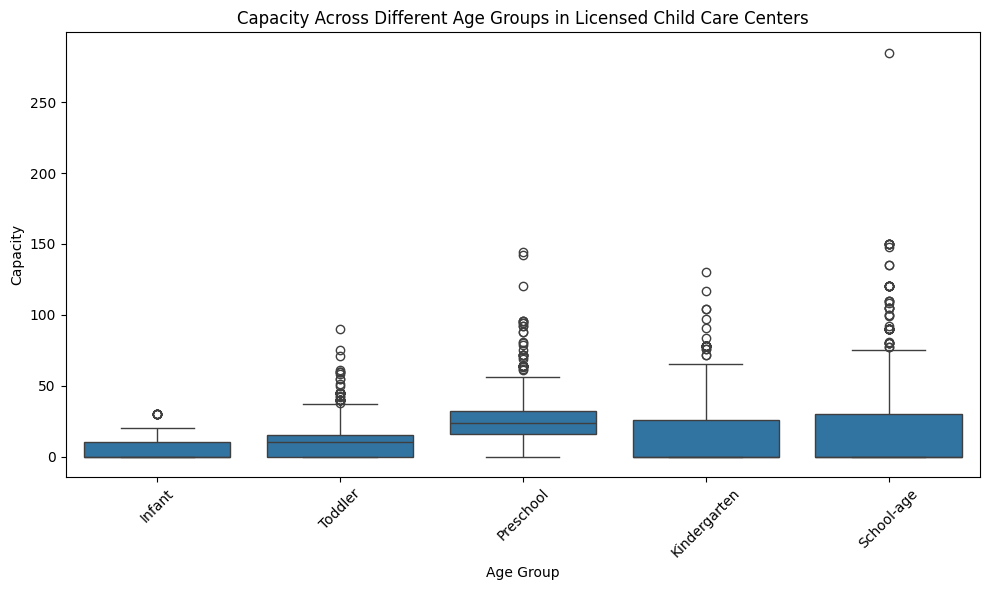

Kruskal-Wallis H test result: KruskalResult(statistic=818.6634260274693, pvalue=6.960346391052689e-176)
Adjusted Post-Hoc Results: {'Infant vs. Toddler': 1.4545849363185713e-68, 'Infant vs. Preschool': 4.969471920658144e-189, 'Infant vs. Kindergarten': 4.71654843432915e-24, 'Infant vs. School-age': 1.7781549643739318e-37, 'Toddler vs. Preschool': 1.0912886903938264e-83, 'Toddler vs. Kindergarten': 0.37535251261714037, 'Toddler vs. School-age': 0.031704306454949954, 'Preschool vs. Kindergarten': 8.082803911800659e-42, 'Preschool vs. School-age': 3.553441869019119e-15, 'Kindergarten vs. School-age': 1.3597767479119088e-06}


In [5]:
# Research Question 1: How does the capacity for childcare vary across different age groups in licensed childcare centers?

# Prepare data for ANOVA
age_group_columns = ['IGSPACE', 'TGSPACE', 'PGSPACE', 'KGSPACE', 'SGSPACE']
age_groups = ['Infant', 'Toddler', 'Preschool', 'Kindergarten', 'School-age']
age_group_data = pd.melt(dataset, value_vars=age_group_columns, var_name='Age Group', value_name='Capacity')
age_group_data['Age Group'] = age_group_data['Age Group'].map(dict(zip(age_group_columns, age_groups)))

# Interaction plot for capacity across age groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age Group', y='Capacity', data=age_group_data)
plt.title('Capacity Across Different Age Groups in Licensed Child Care Centers')
plt.xlabel('Age Group')
plt.ylabel('Capacity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Kruskal-Wallis H test to compare medians across age groups
kruskal_test_result = kruskal(*(age_group_data[age_group_data['Age Group'] == group]['Capacity'] for group in age_groups))

# Post-hoc tests with a correction for multiple comparisons
if kruskal_test_result.pvalue < 0.05:
    post_hoc_results = {}
    for i, group1 in enumerate(age_groups):
        for j, group2 in enumerate(age_groups[i+1:], i+1):
            comparison_label = f"{group1} vs. {group2}"
            group1_data = age_group_data[age_group_data['Age Group'] == group1]['Capacity']
            group2_data = age_group_data[age_group_data['Age Group'] == group2]['Capacity']
            post_hoc_result = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
            post_hoc_results[comparison_label] = post_hoc_result.pvalue

    # Adjust for multiple comparisons
    bonferroni_correction = len(post_hoc_results)
    adjusted_post_hoc_results = {k: v * bonferroni_correction for k, v in post_hoc_results.items()}
    print("Kruskal-Wallis H test result:", kruskal_test_result)
    print("Adjusted Post-Hoc Results:", adjusted_post_hoc_results)
else:
    print("Kruskal-Wallis test was not significant; no post-hoc analysis needed.")


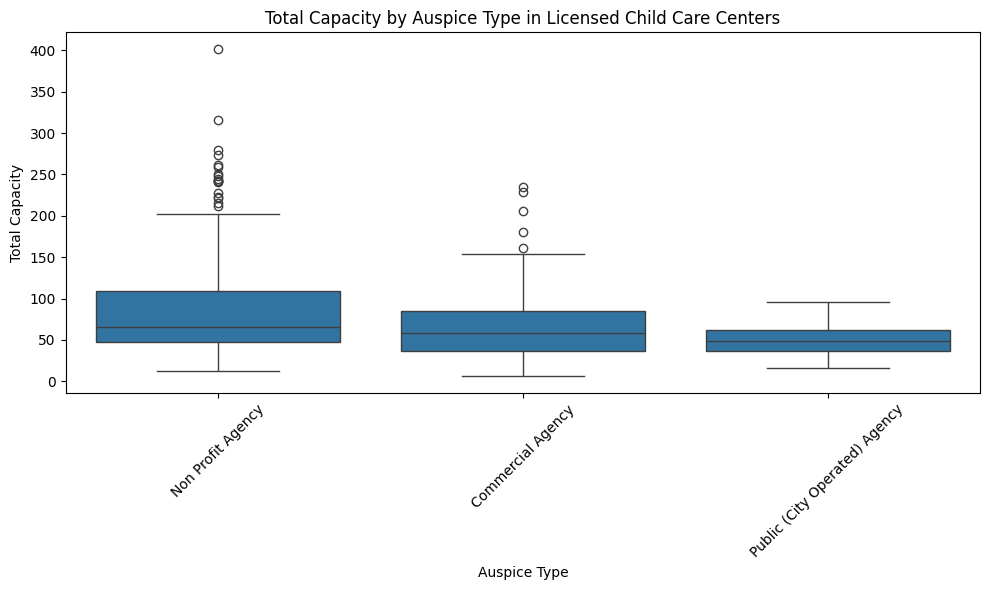

({'Non Profit Agency': ShapiroResult(statistic=0.8917579650878906, pvalue=8.339870811481173e-22),
  'Commercial Agency': ShapiroResult(statistic=0.9238301515579224, pvalue=1.013540900512977e-11),
  'Public (City Operated) Agency': ShapiroResult(statistic=0.9514912962913513, pvalue=0.09225869178771973)},
 LeveneResult(statistic=17.927068524236084, pvalue=2.2036889276494363e-08))

In [6]:
# Research Question 2: Does the type of auspice have an effect on the total capacity of childcare centers?

# Data preparation for auspice type analysis
auspice_data = dataset[['AUSPICE', 'TOTSPACE']].copy()

# Interaction plot for total capacity by auspice type
plt.figure(figsize=(10, 6))
sns.boxplot(x='AUSPICE', y='TOTSPACE', data=auspice_data)
plt.title('Total Capacity by Auspice Type in Licensed Child Care Centers')
plt.xlabel('Auspice Type')
plt.ylabel('Total Capacity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# one-way ANOVA
# Normality test for each auspice type
auspice_types = auspice_data['AUSPICE'].unique()
normality_results_auspice = {auspice: shapiro(auspice_data[auspice_data['AUSPICE'] == auspice]['TOTSPACE']) for auspice in auspice_types}

# Homogeneity of variances test for auspice types
levene_test_result_auspice = levene(*(auspice_data[auspice_data['AUSPICE'] == auspice]['TOTSPACE'] for auspice in auspice_types))

normality_results_auspice, levene_test_result_auspice


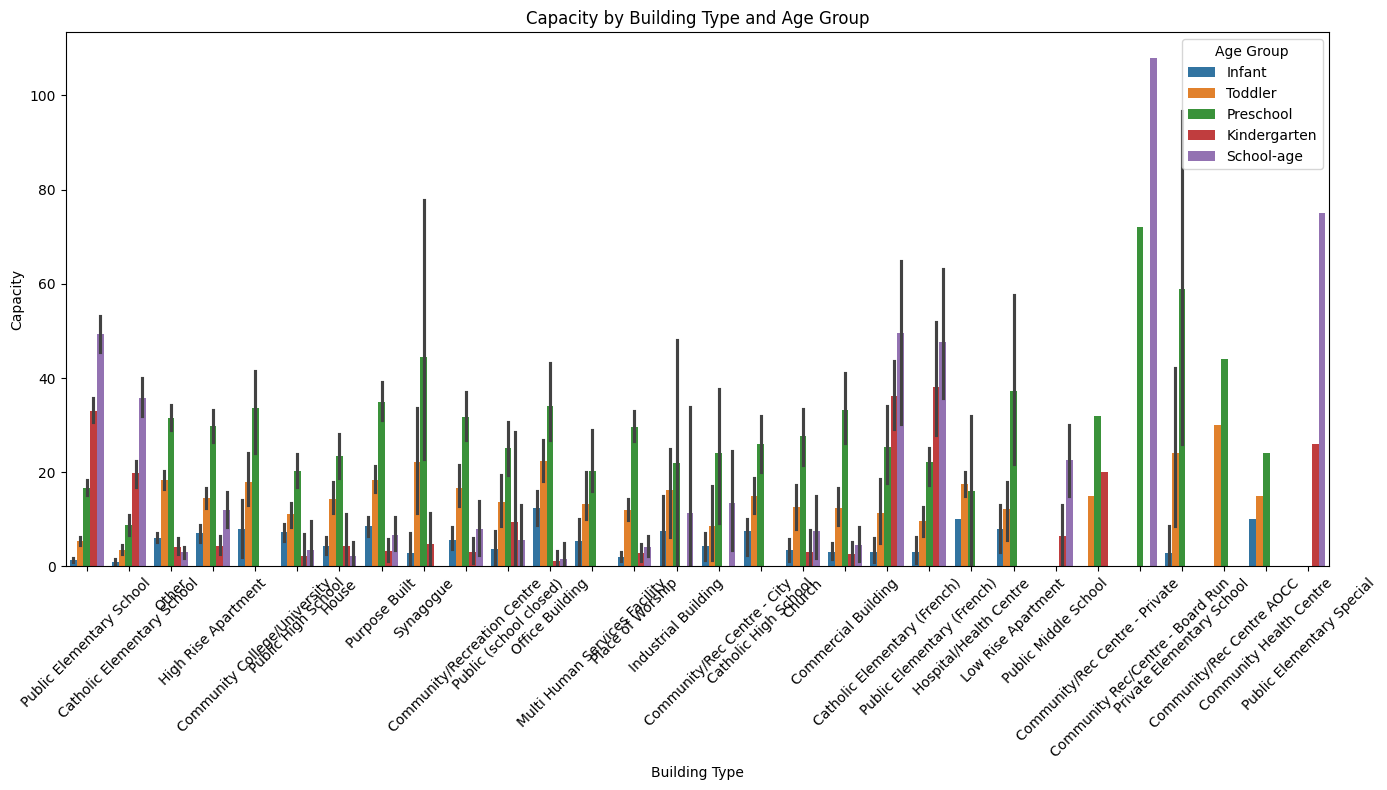

Kruskal-Wallis Test Result for Preschool Age Group: KruskalResult(statistic=249.32680577357215, pvalue=1.9633096847924947e-40)
                                sum_sq      df           F         PR(>F)
C(bldg_type)              1.041138e+05    29.0   15.527176   1.579914e-73
C(AgeGroup)               2.821233e+05     4.0  305.043080  6.918114e-236
C(bldg_type):C(AgeGroup)  6.917570e+05   116.0   25.791573   0.000000e+00
Residual                  1.194230e+06  5165.0         NaN            NaN


In [5]:
# Research Question 3: Is there an interaction effect between building type and age group on the capacity of childcare spaces available?

# Prepare data
age_group_columns = ['IGSPACE', 'TGSPACE', 'PGSPACE', 'KGSPACE', 'SGSPACE']
age_groups = ['Infant', 'Toddler', 'Preschool', 'Kindergarten', 'School-age']
building_age_group_data = dataset[['bldg_type', 'IGSPACE', 'TGSPACE', 'PGSPACE', 'KGSPACE', 'SGSPACE']].copy()
building_age_group_data_long = pd.melt(building_age_group_data, id_vars=['bldg_type'],
                                       value_vars=age_group_columns,
                                       var_name='Age Group', value_name='Capacity')
building_age_group_data_long['Age Group'] = building_age_group_data_long['Age Group'].map(dict(zip(age_group_columns, age_groups)))
building_age_group_data_long['Combined Group'] = building_age_group_data_long['bldg_type'] + ', ' + building_age_group_data_long['Age Group']

# Interaction plot for capacity by building type and age group
plt.figure(figsize=(14, 8))
sns.barplot(x='bldg_type', y='Capacity', hue='Age Group', data=building_age_group_data_long)
plt.title('Capacity by Building Type and Age Group')
plt.xlabel('Building Type')
plt.ylabel('Capacity')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

# Filter combinations with sufficient data
building_age_group_data_long['Count'] = building_age_group_data_long.groupby('Combined Group')['Capacity'].transform('count')
sufficient_data = building_age_group_data_long[building_age_group_data_long['Count'] >= 3]

# Kruskal-Wallis test for a specific age group across different building types
preschool_data = sufficient_data[sufficient_data['Age Group'] == 'Preschool']
building_types = preschool_data['bldg_type'].unique()

# Perform Kruskal-Wallis test
kruskal_results = kruskal(*(preschool_data[preschool_data['bldg_type'] == bldg_type]['Capacity'] for bldg_type in building_types))

print("Kruskal-Wallis Test Result for Preschool Age Group:", kruskal_results)

# Prepare dataset for two-way ANOVA
dataset_long = pd.melt(dataset, id_vars=['bldg_type'], value_vars=['IGSPACE', 'TGSPACE', 'PGSPACE', 'KGSPACE', 'SGSPACE'],
                       var_name='Age Group', value_name='Capacity')

# Rename dataset
dataset_long.rename(columns={'Age Group': 'AgeGroup'}, inplace=True)

# Two-Way ANOVA
model = ols('Capacity ~ C(bldg_type) + C(AgeGroup) + C(bldg_type):C(AgeGroup)', data=dataset_long).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)